## Manually Creating a K-Fold Cross Validation Algorithm
#### Optimizing Recall and Precision for Imbalaced Datasets

### By Mohammed Azhari Gasim (email: mohammedagasim@gmail.com)

#### Introduction
Running classification algorithms on a imbalanced dataset involves the challenge of achieving a high recall score while maintaining a reasonable precision score. Here I attempt to do this with a dataset containing credit card transactions, a small number of which are fraudulent. In the process I demonstrate how to manually create a K-Fold Cross Validation Algorithm that allows the user greater control of hyperparameters. 

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.

I will follow the process below:
1. Running a cross validated Logistic Regression Classification algorithm on the raw data to establish baseline performance.
2. Manually creating a 10-fold cross validated Logistic Regression algorithm.
3. Using the manually created algorithm to adjust probability thresholds.
4. Feature selection using coefficient p-values.

#### The Dataset
First I import the data using pandas.

In [1]:
import pandas as pd
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
dataset.shape

(284807, 31)

This is a large dataset. It is made up of 31 columns and 284,807 samples of real credit card transactions. Most of the columns have, for privacy reasons, been anonymized. The last column is class, a value of 0 indicating a non-fraudulent transaction, and 1 indicating a non-fraudulent transaction. The class column is the target (dependent variable) and the others are the features (independent variables). Next I investigate the number of fraudulent and non-fraudulent transactions.

In [3]:
dataset.Class.value_counts(), dataset.Class.mean()

(0    284315
 1       492
 Name: Class, dtype: int64, 0.001727485630620034)

Out of the 284,807 transactions in the dataset, 284,315 (99.8%) are non-fraudulent and only 492 (0.2%) are fraudulent, meaning that this dataset is highly imbalanced.

#### Establishing a Baseline
To begin with, I will run a cross validated logistic regression classifier to establish baseline recall and precision scores. The accuracy score is irrelevant to this problem. Also note that, due to the highly imbalanced nature of the dataset, the null classifier (a classifier that simply assigns all samples to the most frequently occurring class) would have an accuracy score of 99.8%!

I will use Sci-Kit Learn's LogisticRegerssion and cross_val_score packages. The logistic regression classifier is cross validated over 10 folds. 

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = np.array(dataset.iloc[:, dataset.columns != 'Class'])
y = np.array(dataset.iloc[:, dataset.columns == 'Class']).reshape(len(X),)
results = {}

for score in ['Recall', 'Precision']:
    logreg = LogisticRegression(solver = 'liblinear')
    results[score] = cross_val_score(logreg, X, y, cv = 10, scoring = score.lower()).mean()
print(results)

{'Recall': 0.6085714285714285, 'Precision': 0.8403980762803129}


The results of the baseline classifier are not good. The recall and precision scores are about 61% and 84%, respectively. This means that, of those sample classified as fraudulent, 84% of actually are, however, these themselves make up only 61% of all fraudulent transactions. Using this classifier in a real world application would mean potentially missing 39% of fraudulent credit card transactions.  

The Logistic Regression classifier works by first calculating a probability that a given sample (feature vector) belongs to the fraudulent class. Next it assigns all samples whose probability is greater than a certain threshold to the positive class (in our case that is the fraudulent class). Sci-Kit Learn sets this threshold at 0.5.

By decreasing this threshold we can improve the recall score of the model. However this comes at the cost of a lower level of precision. In short, we will correctly classify more of the fraudulent transactions, but end up with more non-fraudulent transactions being classified as fraudulent as well. The challenge here is to increase the recall score while maintaining a reasonable level of precision. We may get lucky however. It may be the case that we can increase the recall score without a large reduction in precision such that it remains reasonable.

Unfortunately there is no way to adjust the probability threshold on Sci-Kit Learn while using the cross validation. To do so we must build our own folds and test each manually.

#### Creating a K-Fold Cross Validation Algorithm Manually
To create our own cross validation algorithm, we first create 10 folds using Ski-Kit Learn's StratifiedKFold package. The 'Stratified' in the name tells us that it maintains the class distributions in the target when creating the train and test splits. To test that the algorithm performs as expected, I first run it using a probability threshold of 0.5 in order to compare the results to the previous ones. 

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

skf = StratifiedKFold(n_splits = 10)
recall_list = []
precision_list = []
    
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    logreg = LogisticRegression(solver = 'liblinear')
    logreg.fit(X_train, y_train)
    y_pred_proba = logreg.predict_proba(X_test)[:, 1]
    y_pred_class = [1 if p > 0.5 else 0 for p in y_pred_proba]
    recall_list.append(metrics.recall_score(y_test, y_pred_class))
    precision_list.append(metrics.precision_score(y_test, y_pred_class))
results = {'Recall': np.mean(recall_list), 'Precision': np.mean(precision_list)}
print(results)

{'Recall': 0.6085714285714285, 'Precision': 0.8403980762803129}


The results of our algorithm are exactly the same as the ones produced by the built in cross_val_score package. We can now confidently move on to adjusting the probability threshold.

#### Adjusting Probability Threshold
I now wrap my previous algorithm in a for loop to generate results for various probability thresholds (0.01 to 0.1, in increments of 0.01). I also save the recall and precision results for each threshold in recall_all_features and precision_all_features lists. 

In [6]:
skf = StratifiedKFold(n_splits = 10)

recall_all_features = []
precision_all_features = []

for threshold in [i/100 for i in range(1, 11)]:
    recall_list = []
    precision_list = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logreg = LogisticRegression(solver = 'liblinear')
        logreg.fit(X_train, y_train)
        y_pred_proba = logreg.predict_proba(X_test)[:, 1]
        y_pred_class = [1 if p > threshold else 0 for p in y_pred_proba]
        recall_list.append(metrics.recall_score(y_test, y_pred_class))
        precision_list.append(metrics.precision_score(y_test, y_pred_class))
    recall_all_features.append(np.mean(recall_list))
    precision_all_features.append(np.mean(precision_list))
    results = {'Recall': np.mean(recall_list), 'Precision': np.mean(precision_list)}
    print('----------------------------------------------------------------------------')
    print('Threshold: ' + str(threshold))
    print(results)

----------------------------------------------------------------------------
Threshold: 0.01
{'Recall': 0.8102448979591838, 'Precision': 0.38217657300567154}
----------------------------------------------------------------------------
Threshold: 0.02
{'Recall': 0.7755510204081633, 'Precision': 0.5216371629104887}
----------------------------------------------------------------------------
Threshold: 0.03
{'Recall': 0.7634285714285716, 'Precision': 0.5804849842726745}
----------------------------------------------------------------------------
Threshold: 0.04
{'Recall': 0.7532244897959184, 'Precision': 0.62344967815037}
----------------------------------------------------------------------------
Threshold: 0.05
{'Recall': 0.745061224489796, 'Precision': 0.6545254799148028}
----------------------------------------------------------------------------
Threshold: 0.06
{'Recall': 0.7348571428571429, 'Precision': 0.6691622537705219}
------------------------------------------------------------

The results are as expected. As the threshold decreases, the recall score increases and the precision score decreases. At a probability threshold of 0.01, the recall is improved, up from 61% to 81%, a 20 percentage point increase. However, at that level the precision has deteriorated significantly, down from 84% to 38%. In most real life situations, this would not be feasible. However the results do show some improvement. With a threshold of 0.08, the precision is improved, up 11 percentage points to 72%, while the precision level remains above 70%. 

We can attempt to improve these results by performing some feature selection.

#### Feature Selection
The model currently has 30 features. Some may contain more noise than signal, removing those may improve the model.

To identify the most relevant features I will use fit the model using statsmodels Logit package. This will allow me to see the coefficients of the feature variables and the their corresponding p-values (not possible using Sci-Kit Learn). Note that I add a column of ones to as a constant because the Logit package does not assume a bias term by default.

In [7]:
from statsmodels.discrete.discrete_model import Logit

dataset['Constant'] = [1]*len(dataset)
X = dataset.iloc[:, dataset.columns != 'Class']
y = dataset.iloc[:, dataset.columns == 'Class']
del dataset['Constant']

logreg = Logit(y, X)
results = logreg.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.003914
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:               284807
Model:                          Logit   Df Residuals:                   284776
Method:                           MLE   Df Model:                           30
Date:                Sun, 21 Oct 2018   Pseudo R-squ.:                  0.6922
Time:                        11:51:12   Log-Likelihood:                -1114.8
converged:                       True   LL-Null:                       -3621.2
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Time       -3.742e-06   2.26e-06     -1.659      0.097   -8.16e-06    6.79e-07
V1             0.0960      0.042      2.264      0.024       0.013       0.179
V2             0.0094      0.058      0.161      0.872      -0.104       0.123
V3            -0.0079      0.053     -0.149      0.881      -0.112       0.096
V4             0.6986      0.074      9.454      0.000       0.554       0.843
V5             0.1295      0.067      1.944      0.052      -0.001       0.260
V6            -0.1198      0.074     -1.626      0.104      -0.264       0.025
V7            -0.0969      0.067     -1.453      0.146      -0.228       0.034
V8            -0.1739      0.030     -5.711      0.000      -0.234      -0.114
V9            -0.2843      0.111     -2.561      0.010      -0.502      -0.067
V10           -0.8176      0.097     -8.432      0.000      -1.008      -0.628
V11           -0.0621      0.081     -0.762      0.446      -0.222       0.098
V12            0.0909      0.087      1.045      0.296      -0.080       0.261
V13           -0.3312      0.082     -4.058      0.000      -0.491      -0.171
V14           -0.5571      0.062     -8.949      0.000      -0.679      -0.435
V15           -0.1141      0.086     -1.330      0.183      -0.282       0.054
V16           -0.1908      0.125     -1.526      0.127      -0.436       0.054
V17           -0.0216      0.070     -0.309      0.757      -0.159       0.116
V18           -0.0131      0.129     -0.102      0.919      -0.266       0.240
V19            0.0963      0.097      0.993      0.321      -0.094       0.286
V20           -0.4582      0.082     -5.607      0.000      -0.618      -0.298
V21            0.3898      0.060      6.494      0.000       0.272       0.507
V22            0.6297      0.134      4.707      0.000       0.367       0.892
V23           -0.0951      0.058     -1.629      0.103      -0.209       0.019
V24            0.1289      0.147      0.874      0.382      -0.160       0.418
V25           -0.0761      0.131     -0.582      0.560      -0.332       0.180
V26            0.0195      0.190      0.103      0.918      -0.352       0.392
V27           -0.8188      0.122     -6.686      0.000      -1.059      -0.579
V28           -0.2937      0.088     -3.332      0.001      -0.467      -0.121
Amount         0.0009      0.000      2.449      0.014       0.000       0.002
Constant      -8.3917      0.249    -33.652      0.000      -8.880      -7.903
==============================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

We are interested in the p-values of the coefficients. Many of our features seem to be insignificantly different from zero. V17 for example has a p-value of 0.757. Removing those features that are insignificant may improve the results of the model. Next I isolate the features with a p-value of less than 0.05.

Note a better theoretically superior method is to use forward or backward step selection. However, due to the large number of features and samples, this would be computationally expensive.

In [8]:
cols = results.pvalues[results.pvalues < 0.05].index
cols = cols[cols != 'Constant']
cols, len(cols)

(Index(['V1', 'V4', 'V8', 'V9', 'V10', 'V13', 'V14', 'V20', 'V21', 'V22', 'V27',
        'V28', 'Amount'],
       dtype='object'), 13)

There are 13 features (shown above) that have p-values of less than 0.05. Rerunning the regression classifier using only these features may improve the results.

In [9]:
X = np.array(dataset[cols])
y = np.array(dataset.iloc[:, dataset.columns == 'Class']).reshape(len(X),)

features = []
for c in cols:
    features.append(c)
print('Features Used: ' + str(features))

skf = StratifiedKFold(n_splits = 10)

recall_sig_features = []
precision_sig_features = []

for threshold in [i/100 for i in range(1, 11)]:
    recall_list = []
    precision_list = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logreg = LogisticRegression(solver = 'liblinear')
        logreg.fit(X_train, y_train)
        y_pred_proba = logreg.predict_proba(X_test)[:, 1]
        y_pred_class = [1 if p > threshold else 0 for p in y_pred_proba]
        recall_list.append(metrics.recall_score(y_test, y_pred_class))
        precision_list.append(metrics.precision_score(y_test, y_pred_class)) 
    recall_sig_features.append(np.mean(recall_list))
    precision_sig_features.append(np.mean(precision_list))
    results = {'Recall': np.mean(recall_list), 'Precision': np.mean(precision_list)}
    print('----------------------------------------------------------------------------')
    print('Threshold: ' + str(threshold))
    print(results)

Features Used: ['V1', 'V4', 'V8', 'V9', 'V10', 'V13', 'V14', 'V20', 'V21', 'V22', 'V27', 'V28', 'Amount']
----------------------------------------------------------------------------
Threshold: 0.01
{'Recall': 0.8516734693877552, 'Precision': 0.3173983152264528}
----------------------------------------------------------------------------
Threshold: 0.02
{'Recall': 0.8333877551020409, 'Precision': 0.5988223289887722}
----------------------------------------------------------------------------
Threshold: 0.03
{'Recall': 0.815061224489796, 'Precision': 0.6773725986771526}
----------------------------------------------------------------------------
Threshold: 0.04
{'Recall': 0.798734693877551, 'Precision': 0.7088422962417045}
----------------------------------------------------------------------------
Threshold: 0.05
{'Recall': 0.7865306122448981, 'Precision': 0.7380011985012496}
----------------------------------------------------------------------------
Threshold: 0.06
{'Recall': 0.77428

The results have improved. With a precision level of 70%, recall is 80%, an 8 percentage point improvement from the previous model that used all the features. 

Compared to the baseline case, at a threshold of 0.04 and with feature selection, there is a 19 percentage point increase in recall at the cost of 18 percentage point decrease in precision. This is in contrast to the previous model with no feature selection, where ate a threshold of 0.04, there was a smaller 15 percentage point increase in recall at the cost of a larger 22 percentage point decrease in precision.

#### Conclusion

A plot of the recall and precision at each threshold level will help in visualizing the results.

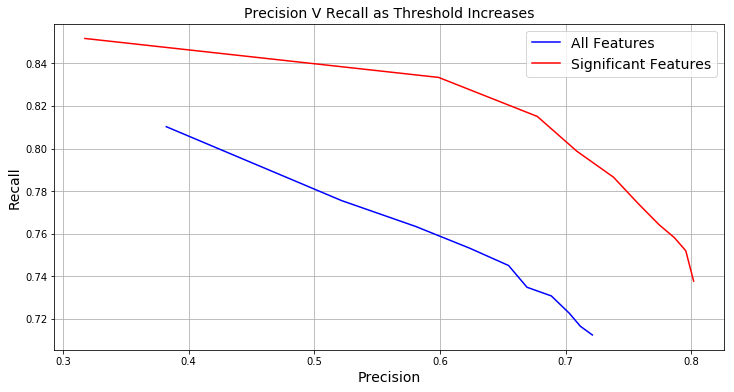

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (12, 6))
plt.plot(precision_all_features, recall_all_features, color = 'blue', label = 'All Features')
plt.plot(precision_sig_features, recall_sig_features, color = 'red', label = 'Significant Features')
plt.title('Precision V Recall as Threshold Increases', fontsize = 14)
plt.xlabel('Precision', fontsize = 14)
plt.ylabel('Recall', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.show()

The negative slope of the curves is a result of the recall precision trade-off. At all thresholds and precision scores, the model with only the significant features has a higher recall score than the model with all features.

This shows that simple feature selection adjustment of threshold probability can markedly improve classification results on imbalanced datasets.